<a href="https://colab.research.google.com/github/ShaunakSen/Deep-Learning/blob/master/TensorFlow_Tutorial_02_Convolutional_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TensorFlow Tutorial #02 Convolutional Neural Network

[link](https://www.youtube.com/watch?v=HMcx-zY8JSg&list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ&index=5&t=389s)

### Introduction

The previous tutorial showed that a simple linear model had about 91% classification accuracy for recognizing hand-written digits in the MNIST data-set.

In this tutorial we will implement a simple Convolutional Neural Network in TensorFlow which has a classification accuracy of about 99%, or more if you make some of the suggested exercises.

Convolutional Networks work by moving small filters across the input image. This means the filters are re-used for recognizing patterns throughout the entire input image. This makes the Convolutional Networks much more powerful than Fully-Connected networks with the same number of variables. This in turn makes the Convolutional Networks faster to train.

The following chart shows roughly how the data flows in the Convolutional Neural Network that is implemented below.


![](https://github.com/Hvass-Labs/TensorFlow-Tutorials/raw/0495ab11a7eef74c2637a9a3fc2ca4bd1eac9022/images/02_network_flowchart.png)

The input image is processed in the first convolutional layer using the filter-weights. This results in 16 new images, one for each filter in the convolutional layer. The images are also down-sampled so the image resolution is decreased from 28x28 to 14x14.

These 16 smaller images are then processed in the second convolutional layer. We need filter-weights for each of these 16 channels, and we need filter-weights for each output channel of this layer. There are 36 output channels so there are a total of 16 x 36 = 576 filters in the second convolutional layer. The resulting images are down-sampled again to 7x7 pixels.

The output of the second convolutional layer is 36 images of 7x7 pixels each. These are then flattened to a single vector of length 7 x 7 x 36 = 1764, which is used as the input to a fully-connected layer with 128 neurons (or elements). This feeds into another fully-connected layer with 10 neurons, one for each of the classes, which is used to determine the class of the image, that is, which number is depicted in the image.

The convolutional filters are initially chosen at random, so the classification is done randomly. The error between the predicted and true class of the input image is measured as the so-called cross-entropy. The optimizer then automatically propagates this error back through the Convolutional Network using the chain-rule of differentiation and updates the filter-weights so as to improve the classification error. This is done iteratively thousands of times until the classification error is sufficiently low.

These particular filter-weights and intermediate images are the results of one optimization run and may look different if you re-run this Notebook.

Note that the computation in TensorFlow is actually done on a batch of images instead of a single image, which makes the computation more efficient. This means the flowchart actually has one more data-dimension when implemented in TensorFlow.

### Convolutional Layer

The following chart shows the basic idea of processing an image in the first convolutional layer. The input image depicts the number 7 and four copies of the image are shown here, so we can see more clearly how the filter is being moved to different positions of the image. For each position of the filter, the dot-product is being calculated between the filter and the image pixels under the filter, which results in a single pixel in the output image. So moving the filter across the entire input image results in a new image being generated.

The red filter-weights means that the filter has a positive reaction to black pixels in the input image, while blue pixels means the filter has a negative reaction to black pixels.

In this case it appears that the filter recognizes the horizontal line of the 7-digit, as can be seen from its stronger reaction to that line in the output image.

![](https://github.com/Hvass-Labs/TensorFlow-Tutorials/raw/0495ab11a7eef74c2637a9a3fc2ca4bd1eac9022/images/02_convolution.png)

The step-size for moving the filter across the input is called the stride. There is a stride for moving the filter horizontally (x-axis) and another stride for moving vertically (y-axis).

In the source-code below, the stride is set to 1 in both directions, which means the filter starts in the upper left corner of the input image and is being moved 1 pixel to the right in each step. When the filter reaches the end of the image to the right, then the filter is moved back to the left side and 1 pixel down the image. This continues until the filter has reached the lower right corner of the input image and the entire output image has been generated.

When the filter reaches the end of the right-side as well as the bottom of the input image, then it can be padded with zeroes (white pixels). This causes the output image to be of the exact same dimension as the input image.

Furthermore, the output of the convolution may be passed through a so-called Rectified Linear Unit (ReLU), which merely ensures that the output is positive because negative values are set to zero. The output may also be down-sampled by so-called max-pooling, which considers small windows of 2x2 pixels and only keeps the largest of those pixels. This halves the resolution of the input image e.g. from 28x28 to 14x14 pixels.

Note that the second convolutional layer is more complicated because it takes 16 input channels. We want a separate filter for each input channel, so we need 16 filters instead of just one. Furthermore, we want 36 output channels from the second convolutional layer, so in total we need 16 x 36 = 576 filters for the second convolutional layer. It can be a bit challenging to understand how this works.

### Imports

In [44]:
import os
work_dir = "/content/TensorFlow-Tutorials/"
if os.getcwd() != work_dir:
  !git clone https://github.com/Hvass-Labs/TensorFlow-Tutorials
os.chdir(work_dir)

Cloning into 'TensorFlow-Tutorials'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 477 (delta 1), reused 3 (delta 1), pack-reused 471
Receiving objects: 100% (477/477), 62.51 MiB | 22.98 MiB/s, done.
Resolving deltas: 100% (222/222), done.


In [45]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

print (tf.__version__)

1.14.0


### Configuration of Neural Network

The configuration of the Convolutional Neural Network is defined here for convenience, so you can easily find and change these numbers and re-run the Notebook.



In [0]:
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

### Load data

In [0]:
from mnist import MNIST
data = MNIST(data_dir="data/MNIST/")

In [48]:

print("Size of:")
print("- Training-set:\t\t{}".format(data.num_train))
print("- Validation-set:\t{}".format(data.num_val))
print("- Test-set:\t\t{}".format(data.num_test))

Size of:
- Training-set:		55000
- Validation-set:	5000
- Test-set:		10000


In [49]:
# The number of pixels in each dimension of an image.
img_size = data.img_size

# The images are stored in one-dimensional arrays of this length.
img_size_flat = data.img_size_flat

# Tuple with height and width of images used to reshape arrays.
img_shape = data.img_shape

# Number of classes, one class for each of 10 digits.
num_classes = data.num_classes

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = data.num_channels

print (img_size, img_size_flat, img_shape, num_classes, num_channels)

28 784 (28, 28) 10 1


In [0]:
# Function used to plot 9 images in a 3x3 grid, and writing the true and predicted classes below each image.

def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

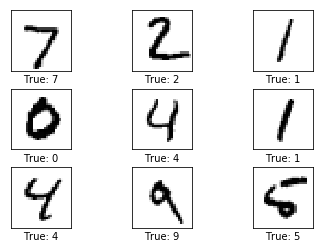

In [51]:
# Plot a few images to see if data is correct


# Get the first images from the test-set.
images = data.x_test[0:9]

# Get the true classes for those images.
cls_true = data.y_test_cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

### Helper-functions for creating new variables

Functions for creating new TensorFlow variables in the given shape and initializing them with random values. Note that the initialization is not actually done at this point, it is merely being defined in the TensorFlow graph.



In [0]:
def new_weights(shape):
  # truncated_normal: Outputs random values from a truncated normal distribution.
  return tf.Variable(tf.truncated_normal(shape=shape, stddev=0.05))


In [0]:
def new_biases(length):
  return tf.Variable(tf.constant(value=0.05, shape=[length]))

### Helper-function for creating a new Convolutional Layer

This function creates a new convolutional layer in the computational graph for TensorFlow. Nothing is actually calculated here, we are just adding the mathematical formulas to the TensorFlow graph.

It is assumed that the input is a 4-dim tensor with the following dimensions:

1. Image number
2. Y axis of each img
3. X axis of each img
4. Channels of each img

Note that the input channels may either be colour-channels, or it may be filter-channels if the input is produced from a previous convolutional layer.

The output is another 4-dim tensor with the following dimensions:

1. Image number, same as input
2. Y-axis of each image. If 2x2 pooling is used, then the height and width of the input images is divided by 2.
3. X-axis of each image. Ditto.
4. Channels produced by the convolutional filters.

In [0]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.
  
  # Shape of the filter-weights for the convolution.
  # This format is determined by the TensorFlow API.
  
  print ("Input shape is:", input.shape)
  
  shape = [filter_size, filter_size, num_input_channels, num_filters]
  
  # Create new weights aka. filters with the given shape.
  weights = new_weights(shape=shape)
  
  # Create new biases, one for each filter.
  biases = new_biases(length=num_filters)
  
  print ("Weights shape:", weights.shape)
  
  # Create the TensorFlow operation for convolution.
  # Note the strides are set to 1 in all dimensions.
  # The first and last stride must always be 1,
  # because the first is for the image-number and
  # the last is for the input-channel.
  # But e.g. strides=[1, 2, 2, 1] would mean that the filter
  # is moved 2 pixels across the x- and y-axis of the image.
  # The padding is set to 'SAME' which means the input image
  # is padded with zeroes so the size of the output is the same.
  
  layer = tf.nn.conv2d(input=input, filter=weights, strides=[1,1,1,1], padding='SAME')
  
  print ("layer shape:", layer.shape)
  
  print ("bias shape:", biases.shape)
  
  # Add the biases to the results of the convolution.
  # A bias-value is added to each filter-channel.
  layer += biases
  
  # Use pooling to down-sample the image resolution?
  
  if use_pooling:
    # This is 2x2 max-pooling, which means that we
    # consider 2x2 windows and select the largest value
    # in each window. Then we move 2 pixels to the next window.
    
    layer = tf.nn.max_pool(value=layer, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    
  # Rectified Linear Unit (ReLU).
  # It calculates max(x, 0) for each input pixel x.
  # This adds some non-linearity to the formula and allows us
  # to learn more complicated functions.
  
  layer = tf.nn.relu(layer)
  
  # Note that ReLU is normally executed before the pooling,
  # but since relu(max_pool(x)) == max_pool(relu(x)) we can
  # save 75% of the relu-operations by max-pooling first.

  # We return both the resulting layer and the filter-weights
  # because we will plot the weights later.
  
  return layer, weights

### Helper-function for flattening a layer

A convolutional layer produces an output tensor with 4 dimensions. We will add fully-connected layers after the convolution layers, so we need to reduce the 4-dim tensor to 2-dim which can be used as input to the fully-connected layer.



In [0]:
def flatten_layer(layer):
  # Get the shape of the input layer.
  layer_shape = layer.get_shape()
  
  # The shape of the input layer is assumed to be:
  # layer_shape == [num_images, img_height, img_width, num_channels]
  
  # The number of features is: img_height * img_width * num_channels
  # We can use a function from TensorFlow to calculate this.
  
  num_features = layer_shape[1:4].num_elements()
  
  # Reshape the layer to [num_images, num_features].
  # Note that we just set the size of the second dimension
  # to num_features and the size of the first dimension to -1
  # which means the size in that dimension is calculated
  # so the total size of the tensor is unchanged from the reshaping.
  
  layer_flat = tf.reshape(layer, shape=[-1, num_features])
  
  # The shape of the flattened layer is now:
  # [num_images, img_height * img_width * num_channels]

  # Return both the flattened layer and the number of features.
  
  return layer_flat, num_features

### Helper-function for creating a new Fully-Connected Layer

This function creates a new fully-connected layer in the computational graph for TensorFlow. Nothing is actually calculated here, we are just adding the mathematical formulas to the TensorFlow graph.

It is assumed that the input is a 2-dim tensor of shape `[num_images, num_inputs]`. The output is a 2-dim tensor of shape `[num_images, num_outputs]`.

In [0]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?
  
  # Create new weights and biases.
  weights = new_weights(shape = [num_inputs, num_outputs])
  biases = new_biases(length=num_outputs)
  
  print ("Input:", input)
  
  print ("Weights and bias shape:", weights.shape, biases.shape)
  
  # Calculate the layer as the matrix multiplication of
  # the input and weights, and then add the bias-values.
  layer = tf.matmul(input, weights) + biases
  
  # Use ReLU?
  if use_relu:
    layer = tf.nn.relu(layer)
  
  
  return layer
  
  

### Placeholder variables

Placeholder variables serve as the input to the TensorFlow computational graph that we may change each time we execute the graph. We call this feeding the placeholder variables and it is demonstrated further below.

First we define the placeholder variable for the input images. This allows us to change the images that are input to the TensorFlow graph. This is a so-called tensor, which just means that it is a multi-dimensional vector or matrix. The data-type is set to float32 and the shape is set to `[None, img_size_flat]`, where None means that the tensor may hold an arbitrary number of images with each image being a vector of length img_size_flat.

In [57]:
x = tf.placeholder(dtype=tf.float32, shape=[None, img_size_flat], name='x')

print (x.shape)

(?, 784)


The convolutional layers expect x to be encoded as a 4-dim tensor so we have to reshape it so its shape is instead `[num_images, img_height, img_width, num_channels]`. Note that `img_height == img_width == img_size` and num_images can be inferred automatically by using -1 for the size of the first dimension. So the reshape operation is:

In [58]:
print (img_size, num_channels)

x_image = tf.reshape(tensor=x, shape=[-1, img_size, img_size, num_channels])

print (x_image.shape)

28 1
(?, 28, 28, 1)


Next we have the placeholder variable for the true labels associated with the images that were input in the placeholder variable x. The shape of this placeholder variable is `[None, num_classes]` which means it may hold an arbitrary number of labels and each label is a vector of length num_classes which is 10 in this case.



In [59]:
y_true = tf.placeholder(dtype=tf.float32, shape=[None, num_classes], name='y_true')

print (y_true.shape)

(?, 10)


We could also have a placeholder variable for the class-number, but we will instead calculate it using argmax. Note that this is a TensorFlow operator so nothing is calculated at this point.



In [60]:
y_true_cls = tf.argmax(input=y_true, axis=1)

print (y_true_cls.shape)

(?,)


### Convolutional Layer 1

Create the first convolutional layer. It takes x_image as input and creates num_filters1 different filters, each having width and height equal to filter_size1. Finally we wish to down-sample the image so it is half the size by using 2x2 max-pooling.



In [61]:
x_image.shape

TensorShape([Dimension(None), Dimension(28), Dimension(28), Dimension(1)])

In [62]:
print (x_image.shape)

# Remember input has to be in shape: [batch, in_height, in_width, in_channels]

layer_conv1, weights_conv1 = new_conv_layer(input=x_image, num_input_channels=num_channels, filter_size=filter_size1, num_filters=num_filters1, use_pooling=True)

print (layer_conv1)

# layer op shape: (?, 14, 14, 16) : [batch_size, img_ht, img_wt, num_channels]

# weights shape: (5,5,1,16): [filter_size, filter_size, num_input_channels, num_filters] as specified earlier

print (weights_conv1.shape)

(?, 28, 28, 1)
Input shape is: (?, 28, 28, 1)
Weights shape: (5, 5, 1, 16)
layer shape: (?, 28, 28, 16)
bias shape: (16,)
Tensor("Relu_3:0", shape=(?, 14, 14, 16), dtype=float32)
(5, 5, 1, 16)


Check the shape of the tensor that will be output by the convolutional layer. It is (?, 14, 14, 16) which means that there is an arbitrary number of images (this is the ?), each image is 14 pixels wide and 14 pixels high, and there are 16 different channels, one channel for each of the filters.



In [63]:
layer_conv1

<tf.Tensor 'Relu_3:0' shape=(?, 14, 14, 16) dtype=float32>

### Convolutional Layer 2

Create the second convolutional layer, which takes as input the output from the first convolutional layer. **The number of input channels corresponds to the number of filters in the first convolutional layer.**



In [64]:
layer_conv2, weights_conv2 = new_conv_layer(input=layer_conv1, num_input_channels=num_filters1, filter_size=filter_size2, num_filters=num_filters2, use_pooling=True)

print (layer_conv2, weights_conv2.shape)

Input shape is: (?, 14, 14, 16)
Weights shape: (5, 5, 16, 36)
layer shape: (?, 14, 14, 36)
bias shape: (36,)
Tensor("Relu_4:0", shape=(?, 7, 7, 36), dtype=float32) (5, 5, 16, 36)


Check the shape of the tensor that will be output from this convolutional layer. The shape is (?, 7, 7, 36) where the ? again means that there is an arbitrary number of images, with each image having width and height of 7 pixels, and there are 36 channels, one for each filter.

### Flatten Layer

The convolutional layers output 4-dim tensors. We now wish to use these as input in a fully-connected network, which requires for the tensors to be reshaped or flattened to 2-dim tensors.



In [65]:
7*7*36

1764

In [66]:
layer_flat, num_features = flatten_layer(layer_conv2)

print (layer_flat, num_features)

Tensor("Reshape_3:0", shape=(?, 1764), dtype=float32) 1764


Check that the tensors now have shape (?, 1764) which means there's an arbitrary number of images which have been flattened to vectors of length 1764 each. Note that 1764 = 7 x 7 x 36.

### Fully-Connected Layer 1

Add a fully-connected layer to the network. The input is the flattened layer from the previous convolution. The number of neurons or nodes in the fully-connected layer is fc_size. ReLU is used so we can learn non-linear relations.



In [67]:

# ip shape : (?,1764) wt shape: (1764, 128) bias: (128,)

# ip*wt + bias = (?, 128)


layer_fc1 = new_fc_layer(input=layer_flat, num_inputs=num_features, num_outputs=fc_size, use_relu=True)

print (layer_fc1)

Input: Tensor("Reshape_3:0", shape=(?, 1764), dtype=float32)
Weights and bias shape: (1764, 128) (128,)
Tensor("Relu_5:0", shape=(?, 128), dtype=float32)


### Fully-Connected Layer 2

Add another fully-connected layer that outputs vectors of length 10 for determining which of the 10 classes the input image belongs to. Note that ReLU is not used in this layer.



In [68]:
layer_fc2 = new_fc_layer(input=layer_fc1, num_inputs=fc_size, num_outputs=num_classes, use_relu=False)

print (layer_fc2)

Input: Tensor("Relu_5:0", shape=(?, 128), dtype=float32)
Weights and bias shape: (128, 10) (10,)
Tensor("add_7:0", shape=(?, 10), dtype=float32)


### Predicted Class

The second fully-connected layer estimates how likely it is that the input image belongs to each of the 10 classes. However, these estimates are a bit rough and difficult to interpret because the numbers may be very small or large, so we want to normalize them so that each element is limited between zero and one and the 10 elements sum to one. This is calculated using the so-called softmax function and the result is stored in y_pred.



In [69]:
y_pred = tf.nn.softmax(logits=layer_fc2)

print (y_pred.shape)

(?, 10)


The class-number is the index of the largest element.

In [70]:
y_pred_cls = tf.argmax(input=y_pred, axis=1)

print (y_pred_cls.shape)

(?,)


### Cost-function to be optimized

To make the model better at classifying the input images, we must somehow change the variables for all the network layers. To do this we first need to know how well the model currently performs by comparing the predicted output of the model y_pred to the desired output y_true.

The cross-entropy is a performance measure used in classification. The cross-entropy is a continuous function that is always positive and if the predicted output of the model exactly matches the desired output then the cross-entropy equals zero. The goal of optimization is therefore to minimize the cross-entropy so it gets as close to zero as possible by changing the variables of the network layers.

TensorFlow has a built-in function for calculating the cross-entropy. **Note that the function calculates the softmax internally so we must use the output of layer_fc2 directly rather than y_pred which has already had the softmax applied.**

In [71]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=layer_fc2, labels=y_true)

print (cross_entropy.shape)

(?,)


We have now calculated the cross-entropy for each of the image classifications so we have a measure of how well the model performs on each image individually. But in order to use the cross-entropy to guide the optimization of the model's variables we need a single scalar value, so we simply take the average of the cross-entropy for all the image classifications.



In [72]:
cost = tf.reduce_mean(input_tensor=cross_entropy)

print (cost.shape)

()


### Optimization Method

Now that we have a cost measure that must be minimized, we can then create an optimizer. In this case it is the AdamOptimizer which is an advanced form of Gradient Descent.

Note that optimization is not performed at this point. In fact, nothing is calculated at all, we just add the optimizer-object to the TensorFlow graph for later execution.

In [0]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

### Performance Measures

We need a few more performance measures to display the progress to the user.

This is a vector of booleans whether the predicted class equals the true class of each image.



In [74]:
correct_prediction = tf.equal(x=y_pred_cls, y=y_true_cls)

print (correct_prediction.shape)

(?,)


This calculates the classification accuracy by first type-casting the vector of booleans to floats, so that False becomes 0 and True becomes 1, and then calculating the average of these numbers.



In [75]:
accuracy = tf.reduce_mean(tf.cast(x=correct_prediction, dtype=tf.float32))

print (accuracy.shape)

()


### Tensorflow Run

### Create TensorFlow session

Once the TensorFlow graph has been created, we have to create a TensorFlow session which is used to execute the graph.



In [0]:
# A class for running TensorFlow operations.

session = tf.Session()

### Initialize variables

The variables for weights and biases must be initialized before we start optimizing them.



In [0]:
session.run(tf.global_variables_initializer())

### Helper-function to perform optimization iterations

There are 55,000 images in the training-set. It takes a long time to calculate the gradient of the model using all these images. We therefore only use a small batch of images in each iteration of the optimizer.

If your computer crashes or becomes very slow because you run out of RAM, then you may try and lower this number, but you may then need to perform more optimization iterations.

In [0]:
train_batch_size = 64


Function for performing a number of optimization iterations so as to gradually improve the variables of the network layers. In each iteration, a new batch of data is selected from the training-set and then TensorFlow executes the optimizer using those training samples. The progress is printed every 100 iterations.



In [79]:
# returns x, y, and y_cls in batches

data.random_batch()[0].shape, data.random_batch()[1].shape, data.random_batch()[2].shape

((32, 784), (32, 10), (32,))

In [0]:
# Counter for total number of iterations performed so far.
total_iterations=0

def optimize(num_iterations):
  # Ensure we update the global variable rather than a local copy.
  global total_iterations
  
  # Start-time used for printing time-usage below.
  start_time = time.time()
  
  for i in range(total_iterations, total_iterations+num_iterations):
    
    # Get a batch of training examples.
    # x_batch now holds a batch of images and
    # y_true_batch are the true labels for those images.
    # _ holds the true class labels
    
    x_batch, y_true_batch, _ = data.random_batch(batch_size=train_batch_size)
    
    # Put the batch into a dict with the proper names
    # for placeholder variables in the TensorFlow graph.
    
    feed_dict_train = {
        x: x_batch,
        y_true: y_true_batch
    }
    
    # Run the optimizer using this batch of training data.
    # TensorFlow assigns the variables in feed_dict_train
    # to the placeholder variables and then runs the optimizer.
    
    session.run(optimizer, feed_dict=feed_dict_train)
    
    # Print status every 100 iterations.
    
    if i%100 == 0:
      # Calculate the accuracy on the training-set.
      acc = session.run(accuracy, feed_dict=feed_dict_train)
      
      # Message for printing.
      msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"
      print (msg.format(i+1, acc))
      
  # Update the total number of iterations performed.
  total_iterations+=num_iterations
  
  #Ending time
  end_time = time.time()
  
  time_diff = end_time-start_time
  
   # Print the time-usage.
  print("Time usage: " + str(timedelta(seconds=int(round(time_diff)))))
  
  
  

### Helper-function to plot example errors

Function for plotting examples of images from the test-set that have been mis-classified.



In [0]:
def plot_example_errors(cls_pred, correct):
  # This function is called from print_test_accuracy() below.
  
  # cls_pred is an array of the predicted class-number for
  # all images in the test-set.
  
  # correct is a boolean array whether the predicted class
  # is equal to the true class for each image in the test-set.
  
  # Negate the boolean array.
  
  incorrect = (correct==False)
  
  # Get the images from the test-set that have been
  # incorrectly classified.
  
  images = data.x_test[incorrect]
  
  # Get the predicted classes for those images.
  cls_pred = cls_pred[incorrect]
  
  # Get the true classes for those images.
  cls_true = data.y_test_cls[incorrect]
  
  # Plot the first 9 images.
  plot_images(images=images[0:9],
              cls_true=cls_true[0:9],
              cls_pred=cls_pred[0:9])

### Helper-function to plot confusion matrix

In [0]:
def plot_confusion_matrix(cls_pred):
  # This is called from print_test_accuracy() below.
  
  # cls_pred is an array of the predicted class-number for
  # all images in the test-set.
  
  # Get the true classifications for the test-set.
  cls_true = data.y_test_cls
  
  # Get the confusion matrix using sklearn.
  cm = confusion_matrix(y_true=cls_true, y_pred=cls_pred)
  
  # Print the confusion matrix as text.
  print(cm)
  
  # Plot the confusion matrix as an image.
  plt.matshow(cm)
  
  # Make various adjustments to the plot.
  plt.colorbar()
  tick_marks = np.arange(num_classes)
  plt.xticks(tick_marks, range(num_classes))
  plt.yticks(tick_marks, range(num_classes))
  plt.xlabel('Predicted')
  plt.ylabel('True')

  # Ensure the plot is shown correctly with multiple plots
  # in a single Notebook cell.
  plt.show()

  

### Helper-function for showing the performance

Function for printing the classification accuracy on the test-set.

It takes a while to compute the classification for all the images in the test-set, that's why the results are re-used by calling the above functions directly from this function, so the classifications don't have to be recalculated by each function.

Note that this function can use a lot of computer memory, which is why the test-set is split into smaller batches. If you have little RAM in your computer and it crashes, then you can try and lower the batch-size.

In [83]:
data.x_test.shape

(10000, 784)

In [84]:
data.y_test_cls.shape

(10000,)

In [0]:
# Split the test-set into smaller batches of this size.
test_batch_size = 256

def print_test_accuracy(show_example_errors=False, show_confusion_matrix=False):
  # Number of images in the test-set.
  num_test = data.num_test
  
  # Allocate an array for the predicted classes which
  # will be calculated in batches and filled into this array.
  
  cls_pred = np.zeros(shape=num_test, dtype=np.int)
  
  # Now calculate the predicted classes for the batches.
  # We will just iterate through all the batches.
  # There might be a more clever and Pythonic way of doing this.

  # The starting index for the next batch is denoted i.
  
  i = 0
  
  while i < num_test:
    # The ending index for the next batch is denoted j.
    j = min(i+test_batch_size, num_test)
    
    # Get the images from the test-set between index i and j.
    images = data.x_test[i:j, :]
    
    # Get the associated labels.
    labels = data.y_test[i:j, :]
    
    # Create a feed-dict with these images and labels.
    feed_dict = {
        x: images,
        y_true: labels
    }
    
    # Calculate the predicted class using TensorFlow.
    
    cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)
    
    # Set the start-index for the next batch to the
    # end-index of the current batch.
    i = j
    
  # at this satge cls_pred is filled with all the test predictions

  # Convenience variable for the true class-numbers of the test-set.
  cls_true = data.y_test_cls
  
  # Create a boolean array storing whether each image is correctly classified
  correct = (cls_true==cls_pred)
  
  # Calculate the number of correctly classified images.
  # When summing a boolean array, False means 0 and True means 1.
  correct_sum = correct.sum()
  
  # Classification accuracy is the number of correctly classified
  # images divided by the total number of images in the test-set.
  
  acc = float(correct_sum) / num_test
  
  # Print the accuracy.
  msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
  print(msg.format(acc, correct_sum, num_test))
  
  # Plot some examples of mis-classifications, if desired.
  if show_example_errors:
      print("Example errors:")
      plot_example_errors(cls_pred=cls_pred, correct=correct)

  # Plot the confusion matrix, if desired.
  if show_confusion_matrix:
      print("Confusion Matrix:")
      plot_confusion_matrix(cls_pred=cls_pred)

  
  

### Performance before any optimization

The accuracy on the test-set is very low because the model variables have only been initialized and not optimized at all, so it just classifies the images randomly.



In [86]:
print_test_accuracy()


Accuracy on Test-Set: 9.8% (982 / 10000)


### Performance after 1 optimization iteration

The classification accuracy does not improve much from just 1 optimization iteration, because the learning-rate for the optimizer is set very low.



In [89]:
optimize(num_iterations=1)


Optimization Iteration:      1, Training Accuracy:   7.8%
Time usage: 0:00:00


In [90]:
print_test_accuracy()


Accuracy on Test-Set: 10.2% (1017 / 10000)


### Performance after 100 optimization iterations

After 100 optimization iterations, the model has significantly improved its classification accuracy.



In [91]:
optimize(num_iterations=99) # We already performed 1 iteration above.

Time usage: 0:00:01


Accuracy on Test-Set: 67.9% (6788 / 10000)
Example errors:


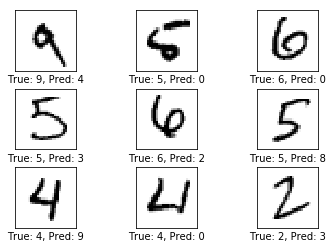

In [92]:
print_test_accuracy(show_example_errors=True)


### Performance after 1000 optimization iterations

After 1000 optimization iterations, the model has greatly increased its accuracy on the test-set to more than 90%.



In [93]:
optimize(num_iterations=900) # We performed 100 iterations above.

Optimization Iteration:    101, Training Accuracy:  60.9%
Optimization Iteration:    201, Training Accuracy:  85.9%
Optimization Iteration:    301, Training Accuracy:  87.5%
Optimization Iteration:    401, Training Accuracy:  89.1%
Optimization Iteration:    501, Training Accuracy:  85.9%
Optimization Iteration:    601, Training Accuracy:  95.3%
Optimization Iteration:    701, Training Accuracy:  93.8%
Optimization Iteration:    801, Training Accuracy:  93.8%
Optimization Iteration:    901, Training Accuracy:  92.2%
Time usage: 0:00:05


Accuracy on Test-Set: 93.1% (9313 / 10000)
Example errors:


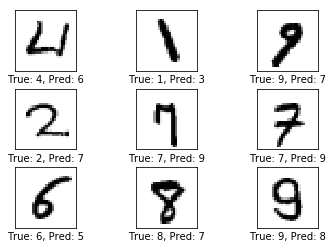

In [94]:
print_test_accuracy(show_example_errors=True)


### Performance after 10,000 optimization iterations

After 10,000 optimization iterations, the model has a classification accuracy on the test-set of about 99%.



In [95]:
optimize(num_iterations=9000) # We performed 1000 iterations above.


Optimization Iteration:   1001, Training Accuracy:  90.6%
Optimization Iteration:   1101, Training Accuracy:  89.1%
Optimization Iteration:   1201, Training Accuracy:  96.9%
Optimization Iteration:   1301, Training Accuracy:  90.6%
Optimization Iteration:   1401, Training Accuracy:  95.3%
Optimization Iteration:   1501, Training Accuracy:  92.2%
Optimization Iteration:   1601, Training Accuracy:  93.8%
Optimization Iteration:   1701, Training Accuracy:  92.2%
Optimization Iteration:   1801, Training Accuracy:  87.5%
Optimization Iteration:   1901, Training Accuracy:  95.3%
Optimization Iteration:   2001, Training Accuracy:  98.4%
Optimization Iteration:   2101, Training Accuracy:  96.9%
Optimization Iteration:   2201, Training Accuracy:  95.3%
Optimization Iteration:   2301, Training Accuracy:  96.9%
Optimization Iteration:   2401, Training Accuracy:  93.8%
Optimization Iteration:   2501, Training Accuracy: 100.0%
Optimization Iteration:   2601, Training Accuracy:  95.3%
Optimization I

Accuracy on Test-Set: 98.4% (9840 / 10000)
Example errors:


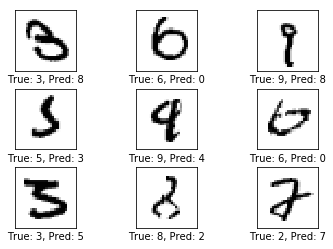

Confusion Matrix:
[[ 974    0    0    0    0    1    1    1    3    0]
 [   0 1128    2    0    1    0    2    0    2    0]
 [   2    2 1018    0    1    0    0    2    7    0]
 [   1    0    4  990    0    5    0    1    9    0]
 [   0    0    0    0  981    0    0    0    1    0]
 [   2    0    0    4    0  875    3    0    6    2]
 [   6    3    0    0   10    4  932    0    3    0]
 [   1    1   11    3    0    0    0 1001    4    7]
 [   4    0    1    0    1    0    0    2  965    1]
 [   1    5    0    0   14    4    0    4    5  976]]


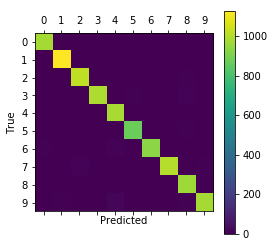

In [96]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)
